In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
import re

#import bokeh
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib_venn import venn3, venn3_circles, venn2
from scipy.stats import norm
import seaborn as sb

import pickle
import json

In [2]:
palette = [
    'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray',
    'tab:olive', 'tab:cyan', 'lightcoral', 'chocolate', 'gold', 'yellow', 'lime', 'aqua', 'dodgerblue',
    'blueviolet', 'deeppink', "#999999", "#777777", 'tab:blue', 
]

palette = palette*10

In [3]:
def venn_diagrams(mut_id, all_values, mut_wt_values):
    mut_name = mut_id.split("@")[1]
    f, ax = plt.subplots(1,2)
    plt.title(mut_name)
    venn3(subsets=all_values, set_labels=('WT', 'MUT', 'CTL'), alpha=0.7, ax=ax[0], set_colors=["#67A9CF","#EF8A62","#888888"]) # ("b","r","g"))
    venn2(subsets=mut_wt_values, set_labels=('WT', 'MUT'), alpha=0.7, ax=ax[1], set_colors=["#67A9CF","#EF8A62"]) #["b", "r"])
    plt.savefig("outputs/single-cells/" + mut_name + "_venn.png")
    plt.close(f)

In [4]:
def visualize_batches(df, x_limits, y_limits, mut_name):
    fig = plt.figure(figsize=(8,8))
    g1 = sb.scatterplot(data=df, x="X", y="Y", hue="Plate", s=10, alpha=0.2)
    g1.set(xlim=x_limits)
    g1.set(ylim=y_limits)
    plt.title(mut_name)
    plt.legend(bbox_to_anchor=(0.85, 1), loc=2, borderaxespad=0.)
        
    plt.savefig("outputs/single-cells/" + mut_name + "_plate.png")
    plt.close(fig)

In [5]:
def visualize_allele(df, x_limits, y_limits, mut_name, layout="dots"):
    fig = plt.figure(figsize=(8,8))
    
    if layout == "dots":
        g1 = sb.scatterplot(data=df, x="X", y="Y", hue="Allele", s=10, alpha=0.2, palette=["#888888","#67A9CF","#EF8A62"]) #["g","b","r"])
    elif layout == "kde":
        g1 = sb.kdeplot(data=df, x="X", y="Y", hue="Allele", alpha=0.5, levels=20, palette=["g","b","r"]) #['tab:blue',"#2CA02C","#FF7F0E"])
    elif layout == "mixed":
        g1 = sb.scatterplot(data=df, x="X", y="Y", hue="Allele", s=10, alpha=0.2, palette=["g","b","r"]) #['tab:blue',"#2CA02C","#FF7F0E"])
        g2 = sb.kdeplot(data=df, x="X", y="Y", hue="Allele", alpha=0.5, levels=10, palette=["g","b","r"]) #['tab:blue',"#2CA02C","#FF7F0E"])
        
    g1.set(xlim=x_limits)
    g1.set(ylim=y_limits)
    plt.title(mut_name)
    plt.savefig("outputs/single-cells/" + mut_name + "_allele.png")
    
    #plt.show()
    plt.close(fig)

In [6]:
def organize_alleles(d, wt_name):
    # Allele names
    allele = []
    allele += ["Control"]*d["controls"]["features"].shape[0]
    allele += ["Wild type"]*d["wild_type_data"]["features"].shape[0]
    for k in d["mutant_ids"]:
        allele += [k.split("@")[-1]]*d["mutants_data"][k]["features"].shape[0]
    
    # Plate names
    plate = []
    plate += ["Control"]*len(d["ctlimgs"]) #[re.match(r"^(.+)/(.+)/(.+)_(.)", x).groups()[1] for x in d["ctlimgs"]]
    plate += [re.match(r"^(.+)/(.+)/(.+)_(.)", x).groups()[1] for x in d["wild_type_data"]["images"]]
    for k in d["mutant_ids"]:
        plate += [re.match(r"^(.+)/(.+)/(.+)_(.)", x).groups()[1] for x in d["mutants_data"][k]["images"]]
    
    # Dataframe
    df = pd.DataFrame(data=d["Y"], columns=["X","Y"])
    df["Allele"] = allele
    df["Plate"] = plate
    
    # Allele colors
    colors = ["#888888","#67A9CF"] + [palette[i] for i in range(len(d["mutant_ids"]))] # + ["green", "blue"]
    
    # Plot limits
    x_limits = (np.percentile(d["Y"][:,0], q=0.0), np.percentile(d["Y"][:,0], q=100)) #99.9))
    y_limits = (np.percentile(d["Y"][:,1], q=0.0), np.percentile(d["Y"][:,1], q=100)) #99.9))
    
    # Plot all alleles
    fig = plt.figure(figsize=(8,8))
    g1 = sb.scatterplot(data=df, x="X", y="Y", s=10, alpha=0.2, hue="Allele", palette=colors)
    g1.set(xlim=x_limits)
    g1.set(ylim=y_limits)
    plt.legend(bbox_to_anchor=(0.85, 1), loc=2, borderaxespad=0.)
    plt.savefig("outputs/single-cells/" + wt_name + "_allele.png")
    
    return df, x_limits, y_limits

595@CCND1_p.E172K 0.2674470457079153


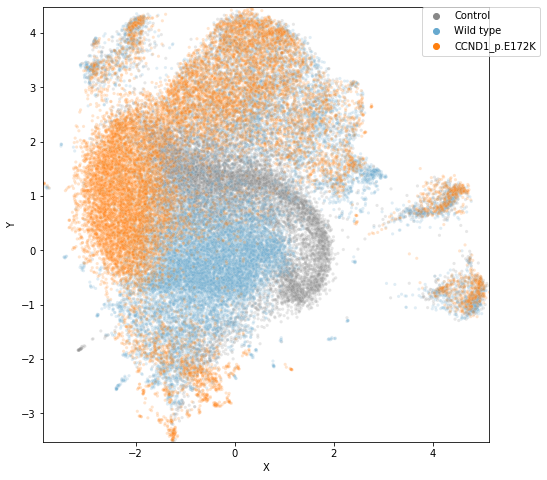

In [7]:
data_dir = "outputs/single-cells/"
wild_types = [k.replace(".pkl", "") for k in os.listdir(data_dir) if k.endswith(".pkl")]

index = {"name":"genes", "children":[]}

for wt in wild_types:
    if not os.path.exists(data_dir + wt + ".pkl"): continue
        
    index["children"].append({"name":wt.split("@")[-1], "children":[]})
    with open(data_dir + wt + ".pkl","rb") as file:
        d = pickle.load(file)
        if not "graph_scores" in d.keys(): continue    
        df, xl, yl = organize_alleles(d, wt.split("@")[-1])
        
        for mut in d["mutant_ids"]:
            # Add JSON entry
            index["children"][-1]["children"].append({"name":mut.split("@")[-1], 
                                                      "pair": wt.split("@")[-1] + "_" + mut.split("@")[-1],
                                                      "impact":d["graph_scores"][mut]["impact_score"],
                                                     })
        
            # Create images
            mut_name = mut.split("@")[-1]
            if not os.path.isfile(mut_name + ".html"):
                subset = df[df.Allele.isin(["Control", "Wild type", mut_name])]
                visualize_allele(subset, xl, yl, mut_name, layout="dots")
                visualize_batches(subset, xl, yl, mut_name)
                
                venn_diagrams(mut, d["graph_scores"][mut]["all_values"], d["graph_scores"][mut]["mut_wt_values"])
                print(mut, d["graph_scores"][mut]["impact_score"])            

json.dump(index, open("outputs/single-cells/alleles.json", "w"))